## Imports 

In [11]:
import numpy as np
import keras
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime, timedelta
import os

## Getting data from yfinance

In [12]:
ticker = 'AAPL'
stockDataName = f'{ticker}_StockData.csv'
end_date = datetime.today()
# print(end_date)
start_date = end_date - timedelta(days=365 * 30)
# print(start_date)
data = yf.download(ticker, start=start_date, end=end_date)
output_path = os.path.join(os.getcwd(), 'dataset', stockDataName)
data.to_csv(output_path)

[*********************100%***********************]  1 of 1 completed


## Cleaning data

In [14]:
# Load data and parse dates
df = pd.read_csv(f'dataset/{stockDataName}', skiprows=[1, 2], parse_dates=['Price'])

# Rename 'Price' to 'Date'
df = df.rename(columns={'Price': 'Date'})
df = df.set_index('Date')

print(df.head())  # Check the first few rows
print(df.isnull().sum())  # Check for missing values

df = df.drop('Volume', axis=1)  # Drop the 'Volume' column

df['Range'] = df['High'] - df['Low']  # Create a new column 'Range'
df = df.drop(['High', 'Low'], axis=1)  # Drop the 'High' and 'Low' columns

# Calculate the 20-day moving average
df['MA-20'] = df['Close'].rolling(window=20).mean()
# Calculate the 50-day moving average
df['MA-50'] = df['Close'].rolling(window=50).mean()
df = df.dropna()  # Drop rows with missing values


# Fill missing values

# Generate a complete date range and forward-fill missing values
df = df.asfreq('D', method='ffill')  # Forward-fill prices on non-trading days
df = df[~df.index.duplicated(keep='first')]  # Remove duplicate dates

# Save cleaned data to a new file
cleanedStockDataName = f'{ticker}_CleanedStockData.csv'
df.to_csv(f'dataset/{cleanedStockDataName}')

               Close      High       Low      Open     Volume
Date                                                         
1995-05-08  0.302087  0.305816  0.296493  0.297425  386971200
1995-05-09  0.307681  0.308614  0.298357  0.303019  322929600
1995-05-10  0.309080  0.312343  0.303951  0.309546  275072000
1995-05-11  0.305816  0.310478  0.301154  0.310478  523622400
1995-05-12  0.325396  0.325862  0.302087  0.304884  647953600
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


## Defining the function to build the model

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Dropout, BatchNormalization,
    AdditiveAttention, Dense, Flatten, Permute, Reshape, Multiply
)
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error



def train_lstm_model(
    csv_path,
    sequence_length=100,
    batch_size=25,
    epochs=100,
    validation_split=0.2,
    patience=10
):
    """
    Trains an LSTM model with attention mechanism on stock Close price data.

    Args:
        csv_path (str): Path to the cleaned CSV file.
        sequence_length (int): Number of days to use for each input sequence.
        batch_size (int): Batch size for model training.
        epochs (int): Number of epochs to train.
        validation_split (float): Fraction of training data to use for validation.
        patience (int): Number of epochs to wait for EarlyStopping.

    Returns:
        model (tf.keras.Model): Trained Keras model.
        history (History object): Training history.
        scaler (MinMaxScaler): Fitted scaler (for inverse transforming predictions later).
    """
    # --- Load and Preprocess Data ---
    data = pd.read_csv(csv_path)
    data = data.drop(columns=['Date'])

    # Scale the 'Close' price
    scaler = MinMaxScaler(feature_range=(0, 1))
    close_scaled = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(close_scaled)):
        X.append(close_scaled[i-sequence_length:i, 0])
        y.append(close_scaled[i, 0])

    X, y = np.array(X), np.array(y)

    # Train/Test Split
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape input for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # --- Build Model ---
    input_layer = Input(shape=(X_train.shape[1], 1))

    x = LSTM(50, return_sequences=True)(input_layer)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = LSTM(50, return_sequences=True)(x)

    # Attention mechanism
    permute = Permute((2, 1))(x)
    reshape = Reshape((50, X_train.shape[1]))(permute)
    attention = AdditiveAttention(name='attention_weight')([reshape, reshape])
    attention = Permute((2, 1))(attention)
    attention = Reshape((X_train.shape[1], 50))(attention)

    x = Multiply()([x, attention])
    x = Flatten()(x)
    output = Dense(1)(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')

    # --- Callbacks ---
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=patience, restore_best_weights=True)
    csv_logger = CSVLogger('training_log.csv')

    # --- Train Model ---
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[early_stopping, csv_logger]
    )

    # --- Evaluate Model ---
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    # rmse = mean_squared_error(y_test, y_pred, squared=False)

    print(f"\nTest MAE: {mae:.5f}")
    # print(f"Test RMSE: {rmse:.5f}")

    return model, history, scaler


def plot_training_history(history, save_path=None):
    """
    Plots the training and validation loss from a Keras model history.

    Args:
        history: History object returned by model.fit()
        save_path (str, optional): If provided, saves the plot to this filepath.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Training vs Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')  # Save the plot
        print(f"Training history plot saved to {save_path}")

    plt.show()

## Building the model

AAPL_CleanedStockData.csv
Epoch 1/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 1.5053e-04 - val_loss: 0.0108
Epoch 2/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 2.0943e-05 - val_loss: 0.0054
Epoch 3/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 1.9339e-05 - val_loss: 0.0020
Epoch 4/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 2.6975e-05 - val_loss: 0.0011
Epoch 5/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 1.5565e-05 - val_loss: 0.0015
Epoch 6/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 1.9494e-05 - val_loss: 2.7031e-04
Epoch 7/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 2.1800e-05 - val_loss: 0.0019
Epoch 8/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 1.9709e-05 - val_loss: 0.0012
Epoch 9/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 1.6708e-05 - val_loss: 0.0016
Epoch 10/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 1.8297e-05 - val_loss: 0.0018
Epoch 11/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 9s 33m

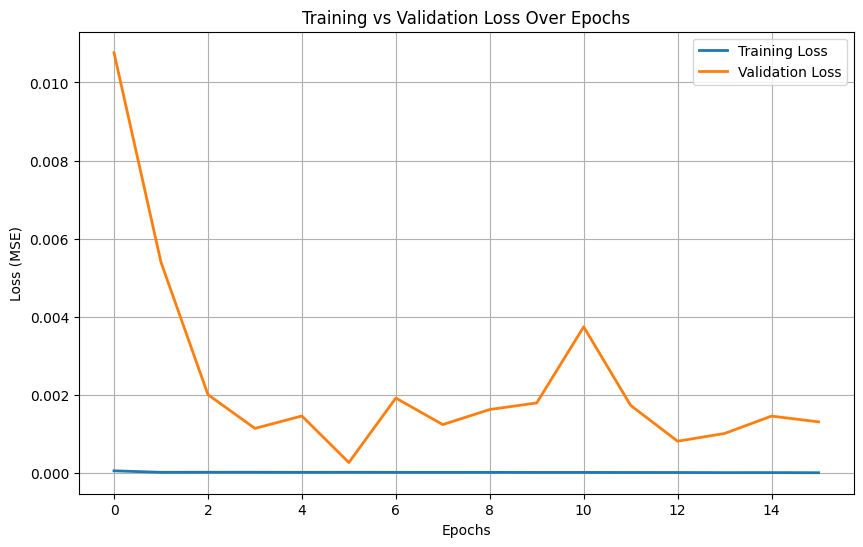

In [16]:
print(cleanedStockDataName)
model, history, scaler = train_lstm_model(f'dataset/{cleanedStockDataName}')
plot_training_history(history, save_path='training_history.png')
model.save('models/my_lstm_model.h5')  # or use .keras